In [1]:
import math as math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)


import warnings
warnings.filterwarnings('ignore')

In [3]:
import route_dynamics.route_elevation.base_df as base
import route_dynamics.route_energy.longi_dynam_model as ldm
from route_dynamics.route_riders import route_riders as ride
from route_dynamics.route_visualizer import visualizer as vis
import route_dynamics.route_energy.knn as knn

In [4]:
shapefile_name = '../data/rt22_pts2.shp'
signals_shp = '../data/traffic_signals2.shp'

In [5]:
data = pd.read_csv("../data/acceleration.csv", names=['time (s)', 'accel. (g)'])

In [6]:
data['time (s)'] = data['time (s)'].round(0)
data['accel. (g)'] = data['accel. (g)'].round(4)

In [7]:
#Convert to SI units
data['accel. (m/s^2)'] = data['accel. (g)']*9.81

In [8]:
#Calculate Velocity

data['vel. (m/s)'] = np.zeros(len(data.index))

for i in range(1, len(data)):
    data['vel. (m/s)'][i] = ((data['accel. (m/s^2)'][i] + data['accel. (m/s^2)'][i-1])/2*1) + data['vel. (m/s)'][i-1]
    
data['vel. (mph)'] = data['vel. (m/s)']*2.2

In [9]:
#Calculate Distance

data['dist. (m)'] = np.zeros(len(data.index))

for i in range(1, len(data)):
    data['dist. (m)'][i] = ((data['vel. (m/s)'][i] + data['vel. (m/s)'][i-1])/2*1) + data['dist. (m)'][i-1]

In [10]:
data['dist (ft)'] = data['dist. (m)']*3.28
data.head()

,time (s),accel. (g),accel. (m/s^2),vel. (m/s),vel. (mph),dist. (m),dist (ft)
0,0.0,0.0006,0.005886,0.000000,0.000000,0.000000,0.000000
1,1.0,0.1156,1.134036,0.569961,1.253914,0.284981,0.934736
2,2.0,0.1239,1.215459,1.744709,3.838359,1.442315,4.730794
3,3.0,0.1261,1.237041,2.970959,6.536109,3.800149,12.464488
4,4.0,0.1256,1.232136,4.205547,9.252203,7.388402,24.233957


In [11]:
#Create new dataframe where dist. is the indep var

data2 = pd.DataFrame({'dist. (ft)': np.arange(0, 1230, 6)})
data2['dist. (m)'] = data2['dist. (ft)']/3.28

data2['vel. (m/s)'] = np.zeros(len(data2.index))

data2['vel. (mph)'] = np.zeros(len(data2.index))

data2['accel. (m/s^2)'] = np.zeros(len(data2.index))

data2['time (s)'] = np.zeros(len(data2.index))

In [12]:
z = data2['dist. (ft)'].iloc[2]
params = data.iloc[(data['dist (ft)']-z).abs().argsort()[:1]]
row = params.index.values

#linear interpolation
vel = ((data['vel. (m/s)'][row].values - data['vel. (m/s)'][row-1].values)/(data['dist. (m)'][row].values - data['dist. (m)'][row-1].values) * (z/3.28 - data['dist. (m)'][row-1].values)) + data['vel. (m/s)'][row-1].values


accel = ((data['accel. (m/s^2)'][row].values - data['accel. (m/s^2)'][row-1].values)/(data['dist. (m)'][row].values - data['dist. (m)'][row-1].values) * (z/3.28 - data['dist. (m)'][row-1].values)) + data['accel. (m/s^2)'][row-1].values


In [13]:
for i in range(1, len(data2)):

    z = data2['dist. (ft)'].iloc[i]
    params = data.iloc[(data['dist (ft)']-z).abs().argsort()[:1]]
    row = params.index.values


    #Interpolate
    if params['dist (ft)'].values < z:
        vel = ((data['vel. (m/s)'][row+1].values - data['vel. (m/s)'][row].values)/(data['dist. (m)'][row +1].values - data['dist. (m)'][row].values) * (z/3.28 - data['dist. (m)'][row].values)) + data['vel. (m/s)'][row].values
        accel = ((data['accel. (m/s^2)'][row+1].values - data['accel. (m/s^2)'][row].values)/(data['dist. (m)'][row +1].values - data['dist. (m)'][row].values) * (z/3.28 - data['dist. (m)'][row].values)) + data['accel. (m/s^2)'][row].values
        time = ((data['time (s)'][row+1].values - data['time (s)'][row].values)/(data['dist. (m)'][row +1].values - data['dist. (m)'][row].values) * (z/3.28 - data['dist. (m)'][row].values)) + data['time (s)'][row].values
    else:
        vel = ((data['vel. (m/s)'][row].values - data['vel. (m/s)'][row-1].values)/(data['dist. (m)'][row].values - data['dist. (m)'][row-1].values) * (z/3.28 - data['dist. (m)'][row-1].values)) + data['vel. (m/s)'][row-1].values
        accel = ((data['accel. (m/s^2)'][row].values - data['accel. (m/s^2)'][row-1].values)/(data['dist. (m)'][row].values - data['dist. (m)'][row-1].values) * (z/3.28 - data['dist. (m)'][row-1].values)) + data['accel. (m/s^2)'][row-1].values
        time = ((data['time (s)'][row].values - data['time (s)'][row-1].values)/(data['dist. (m)'][row].values - data['dist. (m)'][row-1].values) * (z/3.28 - data['dist. (m)'][row-1].values)) + data['time (s)'][row-1].values
        
    
    data2['vel. (m/s)'].iloc[i] = vel
    data2['vel. (mph)'].iloc[i] = vel*2.2
    data2['accel. (m/s^2)'].iloc[i] = accel
    data2['time (s)'].iloc[i] = time

In [14]:
data2.head()

,dist. (ft),dist. (m),vel. (m/s),vel. (mph),accel. (m/s^2),time (s)
0,0,0.000000,0.000000,0.000000,0.000000,0.000000
1,6,1.829268,1.945953,4.281097,1.219001,2.164114
2,12,3.658537,2.897310,6.374081,1.235745,2.939940
3,18,5.487805,3.551620,7.813564,1.234734,3.470328
4,24,7.317073,4.181005,9.198212,1.232234,3.980122


In [15]:
route_df = base.wrapper(shapefile_name, 6, 6)
route_df.head()

,geometry,distance,elevation,speed_limit,grade
0,POINT (-122.38813 47.56295),0.0000,99.398090,11.175682,0.000000
1,POINT (-122.38798 47.56295),10.9728,99.874774,11.175682,0.043442
2,POINT (-122.38784 47.56295),21.9456,100.272354,11.175682,0.036233
3,POINT (-122.38769 47.56295),32.9184,100.594760,11.175682,0.029382
4,POINT (-122.38754 47.56295),43.8912,100.845922,11.175682,0.022889


In [16]:
# Define cutoff distance for acceleration and deceleration
a_pos = 0.4
a_neg = -1.5
a_avg = data2['accel. (m/s^2)'].mean()
a_plt = data2['accel. (m/s^2)'].iloc[len(data2)-1]
x_a = route_df['speed_limit'].iloc[i]**2. / (2*a_avg)
x_d = route_df['speed_limit'].iloc[i]**2. / (2*a_neg)

In [17]:
x_p = data2['dist. (m)'].iloc[34]

x_ns = np.zeros(len(route_df.index)) #next stops
x_ls = np.zeros(len(route_df.index)) # prev. stops

In [18]:
trip_df, riders, mass = ride.route_ridership('PM', 22)
stop_coord, rider_coord = ride.stop_coord(22, riders)
stop_coords = stop_coord.coordinates.values
stop_coords

array([(-122.38433195435942, 47.50819512138902),
       (-122.38166026194457, 47.508170979516095),
       (-122.38159919025402, 47.50652329388237),
       (-122.38061719289107, 47.504660570508065),
       (-122.38093900902744, 47.50282367585952),
       (-122.37941141572873, 47.50057078185344),
       (-122.37758175957335, 47.499317065305775),
       (-122.37607842104967, 47.499927040451524),
       (-122.37605657838178, 47.501240227033506),
       (-122.3760333091399, 47.50264200096122),
       (-122.37596497464583, 47.50457223023829),
       (-122.37693810386416, 47.51379557835211),
       (-122.3792737907224, 47.5138076827721),
       (-122.38213977047363, 47.51382265450292),
       (-122.38475476992342, 47.513836046877465),
       (-122.38608251103078, 47.513842855075694),
       (-122.38869102514143, 47.51350306927917),
       (-122.38882929411479, 47.51081231979928),
       (-122.38820486822239, 47.50995904383726),
       (-122.38673643962859, 47.50821545228435),
       (-122.365

In [19]:
signals = gpd.read_file(signals_shp)
signals = signals[signals['Route_Num']==str(22)]
geometry = signals.geometry.values
xy = []
for i in range(len(geometry)):
    dic = mapping(geometry[i])
    coords = dic['coordinates']
    xy.append(coords)
    xy_df = pd.DataFrame(columns = ['STOP_ID','coordinates'])
    xy_df['coordinates'] = xy
    
xy_df

signal_coords = xy_df.coordinates.values

In [20]:
stop_nn_indicies, stop_coord_nn = knn.find_knn(
1,
route_df.geometry.values,
stop_coords
)


signal_nn_indicies, singal_coord_nn = knn.find_knn(1,route_df.geometry.values, signal_coords)

route_df = route_df.assign(
is_bus_stop = ([False] * len(route_df.index))
)

route_df = route_df.assign(
is_signal = ([False] * len(route_df.index))
)

route_df = route_df.assign(
is_stop = ([False] * len(route_df.index))
)

for i in stop_nn_indicies.ravel():
    route_df.at[i, 'is_bus_stop'] = True
    route_df.at[i, 'is_stop'] = True
    
for i in signal_nn_indicies.ravel()[::2]:
    route_df.at[i, 'is_stop'] = True
    route_df.at[i, 'is_signal'] = True

In [21]:
route_df.head()

,geometry,distance,elevation,speed_limit,grade,is_bus_stop,is_signal,is_stop
0,POINT (-122.38813 47.56295),0.0000,99.398090,11.175682,0.000000,False,False,False
1,POINT (-122.38798 47.56295),10.9728,99.874774,11.175682,0.043442,False,False,False
2,POINT (-122.38784 47.56295),21.9456,100.272354,11.175682,0.036233,False,False,False
3,POINT (-122.38769 47.56295),32.9184,100.594760,11.175682,0.029382,False,False,False
4,POINT (-122.38754 47.56295),43.8912,100.845922,11.175682,0.022889,False,False,False


In [22]:
for i in range(len(x_ns)):
    # set values to Nan if bus stop
    if route_df.at[i, 'is_stop']:
        x_ns[i] = 0.
        x_ls[i] = 0.
        # move to next point
        continue
    else:
        # Calculate 'x_ns';
        # Iterate through remaining indicies to count distance to
        # next stop.
        for j in range(i+1, len(x_ns)):
            # add distance to next point to 'x_ns'
            x_ns[i] += 10.973 
            if route_df.at[j, 'is_stop']:
                break # done calulating 'x_ns' at this point
            # elif not bus stop: move to next point, add distance

        # Calculate 'x_ls';
        # Iterate through previous indicies to cout distance to
        # last stop.
        for j in range(i, 0, -1):
            # Inclusive start to range because distances are
            # backward difference. Dont need to include 'j=0'
            # because the first point has no backward difference.
            if route_df.at[j, 'is_stop']:
                break # done calulating x_ls at this point
            x_ls[i] += 10.973

In [23]:
x_ls

array([ 0.   , 10.973, 21.946, ..., 76.811, 87.784, 98.757])

In [24]:
v = np.zeros(len(route_df.index)) #array for vel.
a = np.zeros(len(route_df.index)) #array for accel.

count = 0

In [25]:
v_lim = route_df['speed_limit'].iloc[i]

for i in range(len(x_ns)):

    if count > i:
        continue

    else:

        #Case 1

        if (
            x_ns[i]<=abs(x_d)
            and
            not route_df.at[i, 'is_stop']
            ):

            if x_ns[i] < x_ls[i]:

                a[i] = a_neg
                v[i] = np.sqrt(-2*x_ns[i]*a_neg)
                count += 1

            else:
                for j in range(len(data2)):

                    if count < len(x_ns):

                        if v[count-1] < v_lim:
                            a[count] = data2['accel. (m/s^2)'].iloc[j]
                            v[count] = data2['vel. (m/s)'].iloc[j]
                            count+=1

                        elif v[count-1]>v_lim:

                            while x_ns[count]>abs(x_d):

                                a[count] = 0
                                v[count] = v_lim

                                count+=1

                            else:
                                continue

                        else:
                            continue

                    else:
                        break
                        
            #Case 2

        elif (
            x_ns[i] > abs(x_d)
            and
            x_ls[i] >= x_p
            and
            not route_df.at[i, 'is_stop']
            ):

            if v[i-1] < v_lim:

                a[i] = a_pos
                v[i] = np.sqrt(2*x_ns[i]*a[i])
                count += 1

            elif v[i-1]>v_lim:

                while x_ns[count]>abs(x_d):

                    a[count] = 0
                    v[count] = v_lim

                    count+=1

                else:
                    continue 

            else:
                continue
        #Case 3

        elif (
            x_ls[i] < x_p
            and
            x_ns[i] > abs(x_d)
            and
            not route_df.at[i, 'is_stop']
            ):

            for j in range(len(data2)):

                if count < len(x_ns):

                    if v[count-1] < v_lim:
                        a[count] = data2['accel. (m/s^2)'].iloc[j]
                        v[count] = data2['vel. (m/s)'].iloc[j]
                        count+=1

                    elif v[count-1]>v_lim:

                        while x_ns[count]>abs(x_d):

                            a[count] = 0
                            v[count] = v_lim

                            count+=1

                        else:
                            continue

                    else:
                        continue

                else:
                    break
                    
        elif route_df.at[i, 'is_stop']:
            count += 1 

In [26]:
back_diff_delta_x = np.full(len(route_df), 10.973)


segment_avg_velocities = (
                v
                +
                np.append(0,v[:-1])
                )/2

delta_times = back_diff_delta_x / segment_avg_velocities
delta_times[delta_times > 1000000] = 0

for i in range(len(route_df)):
    if route_df.at[i, 'is_stop']:
        delta_times[i]+=30 #make variable later
    else:
        pass

time_on_route = np.append(0, np.cumsum(delta_times[1:]))

t = time_on_route
total_time = t[-1]
total_time/60
#should be 62 min

90.82363460856219

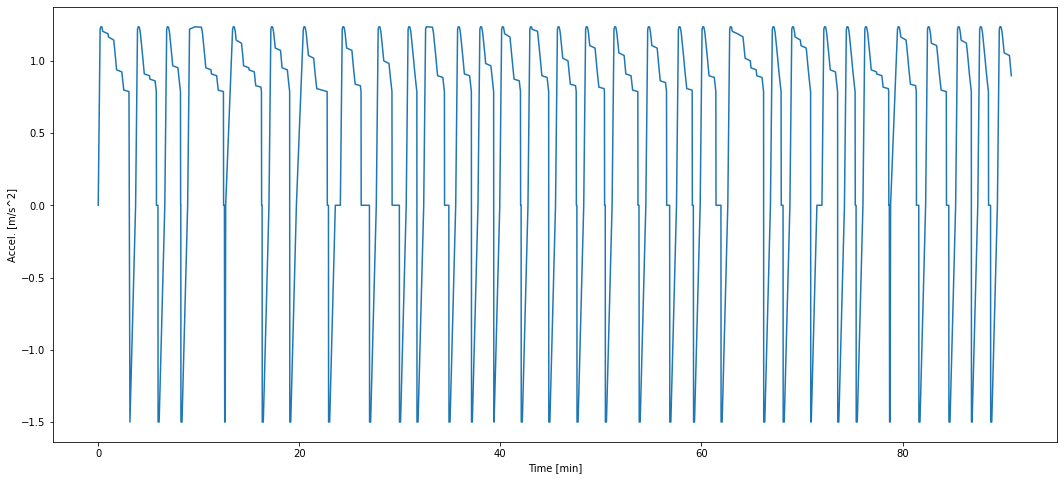

In [29]:
plt.figure(figsize=(18, 8))

plt.plot(t/60, a)
plt.ylabel('Accel. [m/s^2]')
plt.xlabel('Time [min]')
plt.show()

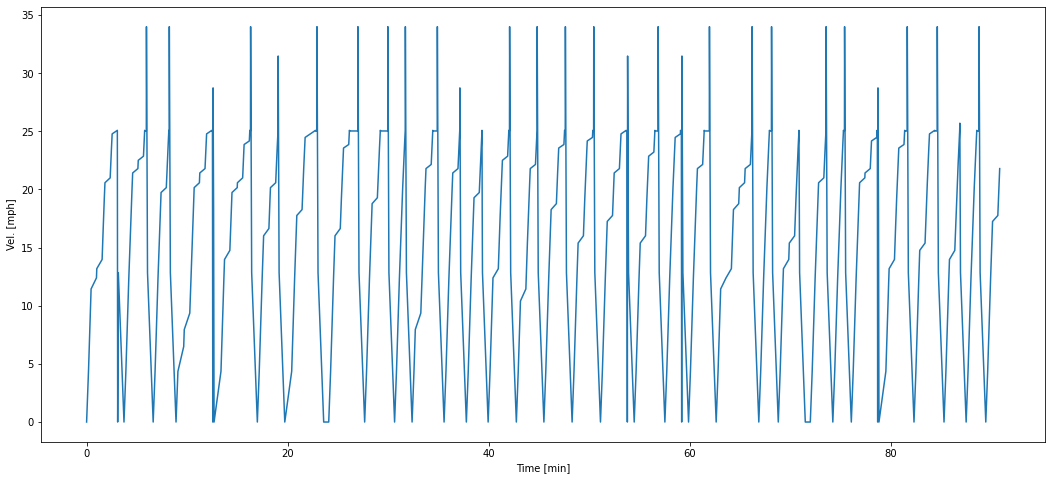

In [28]:
plt.figure(figsize=(18, 8))

plt.plot(t/60, v*2.24)
plt.ylabel('Vel. [mph]')
plt.xlabel('Time [min]')
plt.show()

In [ ]:
np.sum(power*delta_t)

In [ ]:
energy = np.sum(power * delta_t)

In [ ]:
energy

In [ ]:
ex22.energy_from_route() 

In [ ]:
v_lim = 15 #m/s or ~30 mph
a_neg = -0.4

# Define cutoff distance for acceleration and deceleration
a_avg = data2['accel. (m/s^2)'].mean()
a_plt = data2['accel. (m/s^2)'].iloc[len(data2)-1]
x_a = v_lim**2. / (2*a_avg)

# Define cutoff distance for acceleration and deceleration
x_d = v_lim**2. / (2*a_neg)

# Distance of accel profile

x_p = len(data2)*0.3048


In [ ]:
x_ns = np.zeros(len(route_df.index)) #next stops
x_ls = np.zeros(len(route_df.index)) # prev. stops

for i in range(len(x_ns)):
    # set values to Nan if bus stop
    if route_df.at[i, 'is_bus_stop']:
        x_ns[i] = 0.
        x_ls[i] = 0.
        # move to next point
        continue
    else:
        # Calculate 'x_ns';
        # Iterate through remaining indicies to count distance to
        # next stop.
        for j in range(i+1, len(x_ns)):
            # add distance to next point to 'x_ns'
            x_ns[i] += 10.973
            if route_df.at[j, 'is_bus_stop']:
                break # done calulating 'x_ns' at this point
            # elif not bus stop: move to next point, add distance

        # Calculate 'x_ls';
        # Iterate through previous indicies to cout distance to
        # last stop.
        for j in range(i, 0, -1):
            # Inclusive start to range because distances are
            # backward difference. Dont need to include 'j=0'
            # because the first point has no backward difference.
            if route_df.at[j, 'is_bus_stop']:
                break # done calulating x_ls at this point
            x_ls[i] += 10.973


In [ ]:
v = np.zeros(len(route_df.index)) #array for vel.
a = np.zeros(len(route_df.index)) #array for accel.

count = 0

for i in range(len(x_ns)):

    if count > i:
        continue

    else:

        #Case 1

        if (
            x_ns[i]<=abs(x_d)
            and
            not route_df.at[i, 'is_bus_stop']
            ):
            
            if x_ns[i] < x_ls[i]:

                a[i] = a_neg
                v[i] = np.sqrt(-2*x_ns[i]*a_neg)
                count += 1
                
            else:
                for j in range(len(data2)):

                    if count < len(x_ns):

                        if v[count-1] < v_lim:
                            a[count] = data2['accel. (m/s^2)'].iloc[j]
                            v[count] = data2['vel. (m/s)'].iloc[j]
                            count+=1

                        elif v[count-1]>v_lim:

                            while x_ns[count]>abs(x_d):

                                a[count] = 0
                                v[count] = v_lim

                                count+=1

                            else:
                                continue

                        else:
                            continue

                    else:
                        break


        #Case 2

        elif (
            x_ns[i] > abs(x_d)
            and
            x_ls[i] >= x_p
            and
            not route_df.at[i, 'is_bus_stop']
            ):

            if v[i-1] < v_lim:

                a[i] = a_plt
                v[i] = np.sqrt(2*x_ns[i]*a[i])
                count += 1

            elif v[i-1]>v_lim:
                        
                while x_ns[count]>abs(x_d):

                    a[count] = 0
                    v[count] = v_lim

                    count+=1

                else:
                    continue 

            else:
                continue

                    

        #Case 3

        elif (
            x_ls[i] < x_p
            and
            x_ns[i] > abs(x_d)
            and
            not route_df.at[i, 'is_bus_stop']
            ):

            for j in range(len(data2)):

                if count < len(x_ns):

                    if v[count-1] < v_lim:
                        a[count] = data2['accel. (m/s^2)'].iloc[j]
                        v[count] = data2['vel. (m/s)'].iloc[j]
                        count+=1

                    elif v[count-1]>v_lim:
                        
                        while x_ns[count]>abs(x_d):
                
                            a[count] = 0
                            v[count] = v_lim

                            count+=1
                            
                        else:
                            continue
                            
                    else:
                        continue

                else:
                    break


        elif route_df.at[i, 'is_bus_stop']:

            count += 1

In [ ]:
ex22.route_df

In [ ]:
d = {'dist': ex22.route_df.cum_distance, 'last': x_ls, 'next': x_ns, 'stop': ex22.route_df.is_bus_stop, 'accel': a, 'vel':v}

In [ ]:
test = pd.DataFrame(d)

In [ ]:
print (x_d, x_p)

In [ ]:
test.iloc[330:370]

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8,6), dpi=100)

ax1.plot(ex22.route_df.cum_distance, v, label = 'vel')
ax2.plot(ex22.route_df.cum_distance, a, label = 'accel')
#ax.set_xlabel('time (s)') 
#ax.set_ylabel('Power (kW)')
#ax.legend()